In [1]:
import numpy as np
#import gstools as gs
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.sparse import bsr_matrix
from scipy.sparse.linalg import cg

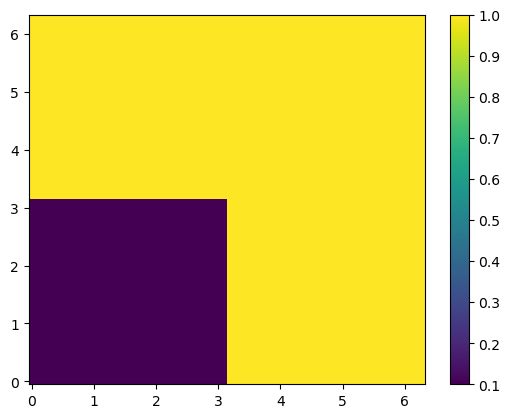

In [2]:
L = 2*np.pi
N = 64 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
def a_function(x,y):
    a = np.where((x<np.pi)&(y<np.pi), 0.1, 1)
    return a
Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()

In [3]:
x1 = XY[0].flatten()
x2 = XY[1].flatten()
triang = Triangulation(x1,x2)

In [4]:
f1 = np.argwhere(x2 == 0).flatten()
f2 = np.argwhere(x2 == L).flatten()
f3 = np.argwhere(x1 == 0).flatten()
f4 = np.argwhere(x1 == L).flatten()

In [5]:
A_matrix = lambda x1, x2 : a_function(x1, x2) * np.eye(2)
xi = np.eye(2)
Q = np.array([[0, -1], [1, 0]])

In [6]:
# Construct global stiffness matrix K 
n_elem = len(triang.triangles)
n_nodes = len(x1)
K = np.zeros((n_nodes, n_nodes))
K_inv = np.zeros((n_nodes, n_nodes))
f = np.zeros((n_nodes, 2))
f_inv = np.zeros((n_nodes, 2))

In [7]:
for i in range(n_elem):
    elem = triang.triangles[i]
    node_coords_x1 = x1[elem]
    node_coords_x2 = x2[elem]
    vector_x1 = node_coords_x1[1:]-node_coords_x1[:-1]
    vector_x2 = node_coords_x2[1:]-node_coords_x2[:-1]
    vectors = np.column_stack((vector_x1, vector_x2, [0, 0]))
    area = (1/2) * abs(np.cross(vectors[0], vectors[1])[-1])
    center = [np.mean(node_coords_x1), np.mean(node_coords_x2)]
    M = np.column_stack(([1, 1, 1], node_coords_x1, node_coords_x2))
    M_inv = np.linalg.inv(M)
    D_grad = M_inv[1:]
    D_curl = np.zeros((2, 3))
    D_curl[0] = -D_grad[1]
    D_curl[1] = D_grad[0]
    A = A_matrix(center[0], center[1])
    A_inv = np.linalg.inv(A)
    K_elem = area * D_grad.T @ A @ D_grad
    K_inv_elem = area * D_curl.T @ A_inv @ D_curl
    K[np.ix_(elem, elem)] += K_elem
    K_inv[np.ix_(elem, elem)] += K_inv_elem
    f_elem = -area * D_grad.T @ A @ xi
    f_inv_elem = -area * D_curl.T @ A_inv @ xi
    f[elem] += f_elem
    f_inv[elem] += f_inv_elem

In [8]:
# Find unique nodes belonging to the master and copy faces in the periodic BCs
master_nodes = np.union1d(f1, f3)
master_nodes = np.setdiff1d(master_nodes, f2)
master_nodes = np.setdiff1d(master_nodes, f4)
copy_nodes = np.union1d(f2, f4)
copy_nodes = np.setdiff1d(copy_nodes, master_nodes)
free_nodes = np.setdiff1d(np.arange(n_nodes), copy_nodes)
n_master = len(master_nodes)
n_free = len(free_nodes)

In [9]:
K_copy = K.copy()
K_copy[:,f1] += K_copy[:,f2]
K_copy[f1,:] += K_copy[f2,:]
K_copy[:,f3] += K_copy[:,f4]
K_copy[f3,:] += K_copy[f4,:]
K_per = K_copy[np.ix_(free_nodes, free_nodes)]

K_inv_copy = K_inv.copy()
K_inv_copy[:,f1] += K_inv_copy[:,f2]
K_inv_copy[f1,:] += K_inv_copy[f2,:]
K_inv_copy[:,f3] += K_inv_copy[:,f4]
K_inv_copy[f3,:] += K_inv_copy[f4,:]
K_inv_per = K_inv_copy[np.ix_(free_nodes, free_nodes)]

In [10]:
f_copy = f.copy()
f_copy[f1] += f_copy[f2]
f_copy[f3] += f_copy[f4]
f_per = f_copy[free_nodes]

f_inv_copy = f_inv.copy()
f_inv_copy[f1] += f_inv_copy[f2]
f_inv_copy[f3] += f_inv_copy[f4]
f_inv_per = f_inv_copy[free_nodes]

In [11]:
U_per_1 = cg(bsr_matrix(K_per), f_per[:,0], tol=1e-6)
U_per_2 = cg(bsr_matrix(K_per), f_per[:,1], tol=1e-6)
W_per_1 = cg(bsr_matrix(K_inv_per), f_inv_per[:,0], tol=1e-6)
W_per_2 = cg(bsr_matrix(K_inv_per), f_inv_per[:,1], tol=1e-6)

In [12]:
U = np.zeros((n_nodes,2))
W = np.zeros((n_nodes,2))
U[free_nodes, 0] = U_per_1[0]
U[free_nodes, 1] = U_per_2[0]
W[free_nodes, 0] = W_per_1[0]
W[free_nodes, 1] = W_per_2[0]
U[f2] = U[f1]
U[f4] = U[f3]
W[f2] = W[f1]
W[f4] = W[f3]

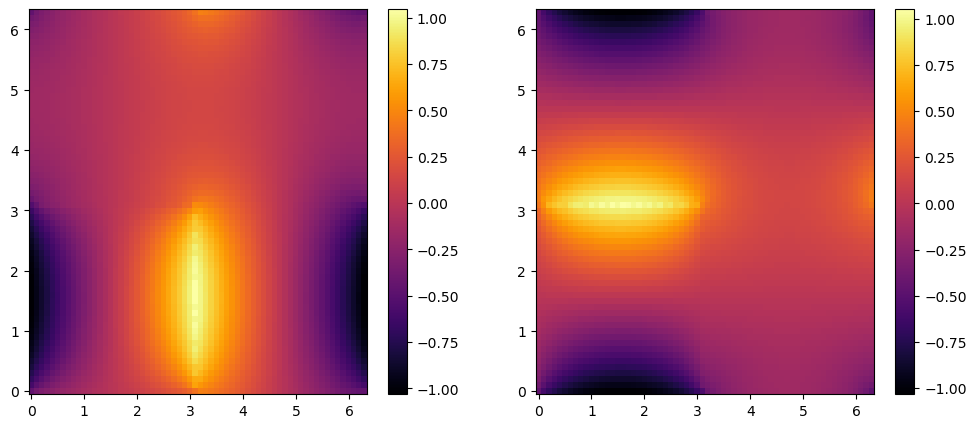

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], U[:,0].reshape(N, N), cmap='inferno')
pos2 = axs[1].pcolormesh(XY[0], XY[1], U[:,1].reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
fig.colorbar(pos2, ax=axs[1])

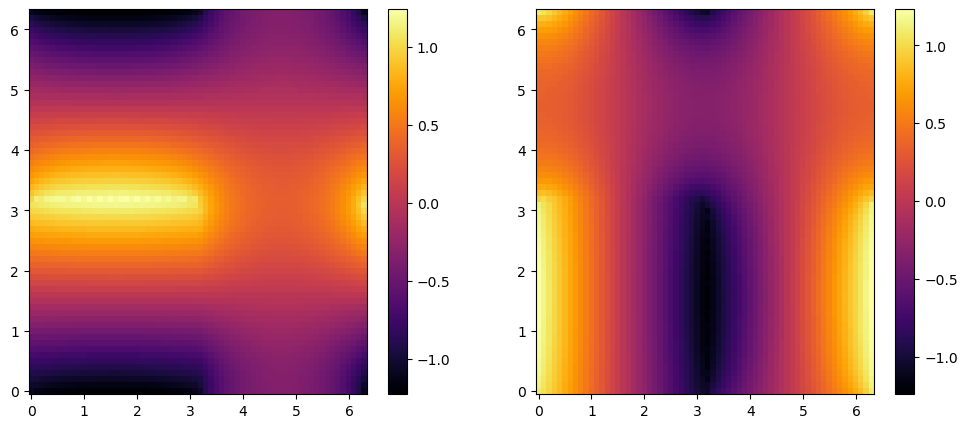

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], W[:,0].reshape(N, N), cmap='inferno')
pos2 = axs[1].pcolormesh(XY[0], XY[1], W[:,1].reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
fig.colorbar(pos2, ax=axs[1])

In [43]:
# Compute the A_h, B_h2 - upper and lower bounds to the homogenized parameters
A_h = np.zeros((2,2))
B_h = np.zeros((2,2))
for i in range(n_elem):
    elem = triang.triangles[i]
    node_coords_x1 = x1[elem]
    node_coords_x2 = x2[elem]
    vector_x1 = node_coords_x1[1:]-node_coords_x1[:-1]
    vector_x2 = node_coords_x2[1:]-node_coords_x2[:-1]
    vectors = np.column_stack((vector_x1, vector_x2, [0, 0]))
    area = (1/2) * abs(np.cross(vectors[0], vectors[1])[-1])
    center = [np.mean(node_coords_x1), np.mean(node_coords_x2)]
    A = A_matrix(center[0], center[1])
    A_inv = np.linalg.inv(A)
    M = np.column_stack(([1, 1, 1], node_coords_x1, node_coords_x2))
    M_inv = np.linalg.inv(M)
    D_grad = M_inv[1:]
    D_curl = np.zeros((2, 3))
    D_curl[0] = -D_grad[1]
    D_curl[1] = D_grad[0]
    g_elem = D_grad @ U[elem] + xi
    curl = D_curl @ W[elem] + xi  
    A_h_elem = area * g_elem.T @ A @ g_elem
    A_h += A_h_elem
    B_h_elem = area * curl.T @ A_inv @ curl
    B_h += B_h_elem

print(np.linalg.inv(B_h / L**2))
print(A_h / L**2)

[[ 6.43295300e-01 -2.85009461e-04]
 [-2.85009461e-04  6.43210098e-01]]
[[ 6.49022005e-01 -2.59032617e-04]
 [-2.59032617e-04  6.49029876e-01]]
